In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import folium
from folium.plugins import HeatMap

In [11]:
data = pd.read_csv('C:/Users/User/OneDrive - Institut Teknologi Sepuluh Nopember/02.Research/01.self/pirates_detection/Maritime-Pirate-Attacks/data/csv/pirate_attacks.csv')
print(data.head())
print(data.info())

         date time  longitude   latitude attack_type  \
0  1993-01-02  NaN   116.9667  19.700000         NaN   
1  1993-01-04  NaN   116.0000  22.350000         NaN   
2  1993-01-06  NaN   115.2500  19.670000         NaN   
3  1993-01-08  NaN   124.5833  29.900000         NaN   
4  1993-01-12  NaN   120.2667  18.133333         NaN   

         location_description nearest_country eez_country  shore_distance  \
0  Hong Kong - Luzon - Hainan             CHN         TWN      357.502373   
1  Hong Kong - Luzon - Hainan             CHN         CHN       47.431573   
2  Hong Kong - Luzon - Hainan             CHN         TWN      280.811871   
3              East China Sea             CHN         CHN      209.923396   
4  Hong Kong - Luzon - Hainan             PHL         PHL       22.027332   

   shore_longitude  shore_latitude attack_description           vessel_name  \
0       115.825956       22.746644                NaN      Mv Cosmic Leader   
1       115.825956       22.746644        

### Feature Engineering

In [15]:
# Selecting relevant columns for anomaly detection
data_model = data[['longitude', 'latitude', 'shore_distance']]

# Handle missing values
if data_model.isnull().sum().sum() > 0:
    print("Handling missing values...")
    data_model = data_model.dropna()

In [16]:
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_model)

In [17]:
train_data, test_data = train_test_split(data_scaled, test_size=0.2, random_state=42)

In [18]:
input_dim = train_data.shape[1]
input_layer = Input(shape=(input_dim,))

In [19]:
# Encoder
encoded = Dense(64, activation='relu')(input_layer)
encoded = Dense(32, activation='relu')(encoded)
encoded = Dense(16, activation='relu')(encoded)

# Decoder
decoded = Dense(32, activation='relu')(encoded)
decoded = Dense(64, activation='relu')(decoded)
decoded = Dense(input_dim, activation='sigmoid')(decoded)

# Model
autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer='adam', loss='mse')


In [20]:
# Train the autoencoder
autoencoder.fit(train_data, train_data, epochs=50, batch_size=32, shuffle=True, validation_split=0.2, verbose=1)


Epoch 1/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.9945 - val_loss: 0.5958
Epoch 2/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 934us/step - loss: 0.6162 - val_loss: 0.5842
Epoch 3/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step - loss: 0.6199 - val_loss: 0.5836
Epoch 4/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step - loss: 0.5994 - val_loss: 0.5829
Epoch 5/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step - loss: 0.6085 - val_loss: 0.5828
Epoch 6/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 944us/step - loss: 0.5692 - val_loss: 0.5826
Epoch 7/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step - loss: 0.5830 - val_loss: 0.5825
Epoch 8/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 944us/step - loss: 0.6099 - val_loss: 0.5826
Epoch 9/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 937us/step - loss: 0.5892 - val_loss: 0.5828
Epoch 10/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step - loss: 0.5734 - val_loss: 0.5823
Epoch 11/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 930us/step - loss: 0.6236 - val_loss: 0.5822
Epoch 12/50
151/151 ━━━━━━━━━━━━

In [21]:
reconstructed_data = autoencoder.predict(test_data)
mse = np.mean(np.power(test_data - reconstructed_data, 2), axis=1)
threshold = np.percentile(mse, 95)  # Define threshold as 95th percentile of reconstruction error

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


In [22]:
data['reconstruction_error'] = np.nan
data.loc[data.index[-len(test_data):], 'reconstruction_error'] = mse

In [23]:
data['anomaly'] = data['reconstruction_error'].apply(lambda x: 1 if x > threshold else 0)


In [24]:
normal_data = data[data['anomaly'] == 0]
anomalies = data[data['anomaly'] == 1]

In [25]:
map_center = [data['latitude'].mean(), data['longitude'].mean()]
map_ = folium.Map(location=map_center, zoom_start=6)

In [26]:
for _, row in normal_data.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=2,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.5,
    ).add_to(map_)

In [27]:
for _, row in anomalies.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=4,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.7,
    ).add_to(map_)

In [28]:
heatmap_data = data[['latitude', 'longitude', 'anomaly']].values.tolist()
HeatMap(heatmap_data, radius=15).add_to(map_)

In [29]:
map_.save("maritime_anomalies_map_autoencoder.html")
print("Map with anomalies saved as 'maritime_anomalies_map_autoencoder.html'.")


Map with anomalies saved as 'maritime_anomalies_map_autoencoder.html'.


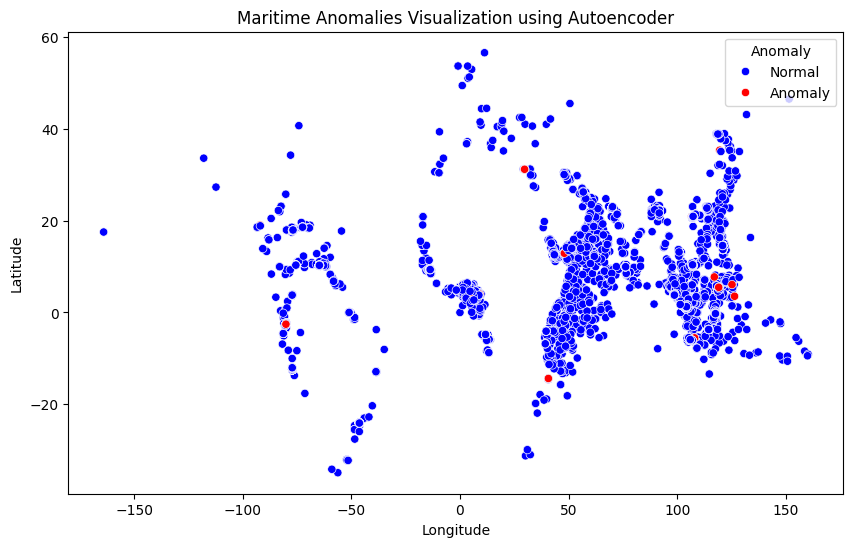

In [49]:
plt.figure(figsize=(10, 6))

sns.scatterplot(x='longitude', y='latitude', hue='anomaly', data=data, palette={0: 'blue', 1: 'red'})
plt.title("Maritime Anomalies Visualization using Autoencoder")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
handles, labels = plt.gca().get_legend_handles_labels()
labels = ['Normal', 'Anomaly']  # Rename the legend labels
plt.legend(handles=handles, labels=labels, title="Anomaly", loc='upper right')
plt.show()